In [2]:
from __future__ import print_function

import scipy as sp
import scipy.misc
import os
import imageio
import ast
import skimage
import imageio
from itertools import islice
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from math import log10
import easydict

from IPython.display import clear_output
from IPython.core.debugger import set_trace

from torchvision.transforms import Resize, ToTensor, Normalize
import re
import torch
from torch import nn 
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.backends.cudnn as cudnn
import torchvision


from tqdm import tqdm_notebook

from shutil import rmtree
import json
from IPython.display import clear_output
from torch import autograd

from skimage import io
from skimage.feature import canny
from skimage.morphology import dilation, disk
from skimage.color import rgb2gray

from networks import define_G, define_D, GANLoss, get_scheduler, update_learning_rate
from data import get_training_set, get_test_set

# Meta-Parameters

In [0]:
batch_size = 32
input_nc = 1
output_nc = 3
ngf = 64
ndf = 64
epoch_count = 1
niter = 200
niter_decay = 200
lr = 0.0002
lr_policy = 'lambda'
lr_decay_iters = 50
beta1 = 0.5
cuda = True
threads = 4
seed = 123
lamb = 10
device = torch.device("cuda:0")
VIS_FREQ = 10
SAVE_FREQ = 50


opt = easydict.EasyDict({"lr_policy":lr_policy,
                        "epoch_count":epoch_count,
                        "niter_decay":niter_decay,
                        "lr_decay_iters":lr_decay_iters,
                        "niter":niter})

cudnn.benchmark = True
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [0]:
class FashionEdgesDataset(Dataset):
    def __init__(self, images_fold, attr_file=None, check_corrupted=False):
        
        self.corrupted_images = set()
        self.check_corrupted = check_corrupted
        self.images_fold = images_fold
        
        if attr_file is not None:
            images2attr_dict = {}
            with open(attr_file, 'r') as f:
                dicts = f.readlines()
            for d in tqdm_notebook(dicts):
                dct = ast.literal_eval(d)
                image_name = dct['image']
                
                if check_corrupted:
                    img = Image.open(os.path.join(self.images_fold, image_name))
                    if not self._is_appropriate(np.array(img)):
                        self.corrupted_images.add(image_name)
                        continue

                images2attr_dict[image_name] = dct['attributes']
                
            self.images2attr = images2attr_dict
            self.images_names = list(images2attr_dict.keys())
        else:
            self.images_names = os.listdir(self.images_fold)

    def _image2edges(self, image, low_thresh=0.05, high_thresh=0.3, sigma=0.1, selem=True, d = 1.5):
  
        image_gray_rescaled = rgb2gray(image)
        edges = canny(image_gray_rescaled, sigma = sigma, low_threshold=low_thresh, high_threshold=high_thresh)
        if selem:
            selem = disk(d)
            edges = dilation(edges, selem)
  
        return edges
    
    def _is_appropriate(self, img, thresh = 10):
    
        return np.all(img[:thresh,:thresh] == 255)
    
    def __getitem__(self, idx):
        
        image_name = self.images_names[idx]
        img = Image.open(os.path.join(self.images_fold, image_name))#.convert('RGB')        
#         if not self.check_corrupted and not self._is_appropriate(np.array(img)):
#             return None
        
        img = Resize((128, 128))(img)
        
        img = ToTensor()(img)
        if img.shape[0] > 3:
            img = img[:3]
        
        edges = self._image2edges(tensor2numpy(img))
        
        return torch.tensor(edges, dtype=torch.float32).unsqueeze(0), img

    def __len__(self):
        return len(self.images_names)

def tensor2numpy(img):
    return img.permute(1,2,0).cpu().numpy()
  
    
def vis_batch(batch, number):
    l = min(int(np.sqrt(batch_size)),int(np.sqrt(number)))
    fig, axes = plt.subplots(nrows = l , ncols = l, figsize = (2*l,2*l))
    iterable = [axes] if l == 1 else axes.flatten()
    for i, ax in enumerate(iterable):

        img_i = batch[i]
        rgb = (img_i.shape[0] == 3)
        img_i = tensor2numpy(img_i) if rgb else img_i[0].cpu().numpy()
        ax.imshow(img_i)
        ax.set_xticks([])
        ax.set_yticks([])

        
def save(exp_path,epoch,netD,netG,optimizerD,optimizerG,loss_d_history,loss_g_history,loss_g_l1_history,loss_g_gan_history):
    dict_to_save = {
        "Discriminator":netD.state_dict(),
        "Generator":netG.state_dict(),
        "OptDiscriminator":optimizerD.state_dict(),
        "OptGenerator":optimizerG.state_dict(),
        "loss_g_history":loss_g_history,
        "loss_d_history":loss_d_history,
        "loss_g_l1_history":loss_g_l1_history,
        "loss_g_gan_history":loss_g_gan_history
    }
    
    path = os.path.join(exp_path,"iter{0}_lr{1}".format(epoch,lr))
    torch.save(dict_to_save, path)
    
def save_batch(batch, folder = './results'):
    
    for tensor in batch:
    
        names = os.listdir(folder)
        last_number = 0 if names == [] else int(re.findall('\d+', sorted(names, key=lambda x: int(re.findall('\d+',x)[0]))[-1])[0])
        plt.figure(figsize=(5,5))
        plt.imshow(tensor2numpy(tensor.detach()))
        plt.xticks([])
        plt.yticks([])
        plt.savefig(os.path.join(folder,'{}.jpg'.format(last_number+1)))
    
    

In [0]:
def collate_fn(items):
    items = list(filter(lambda x: x is not None, items))

    if len(items) == 0:
        print("All items in batch are None")
        return None
    
    batch = (torch.stack([item[0] for item in items]), torch.stack([item[1] for item in items]))
    
    return batch  

In [7]:
images_fold, attributes_path = '../cp-vton/', '../attributes.json'
# images_fold, attributes_path = '../hoodie/', None
train_set = FashionEdgesDataset(images_fold, attributes_path)
training_data_loader = DataLoader(dataset=train_set,
                                  batch_size=32, 
                                  collate_fn = collate_fn,
                                  shuffle=True)

In [0]:
for batch in training_data_loader:
    break


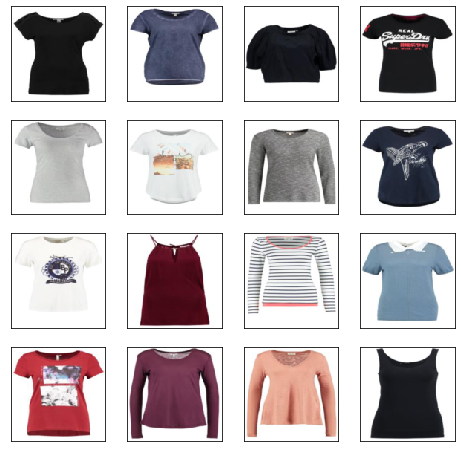

In [10]:
vis_batch(batch[1],16)

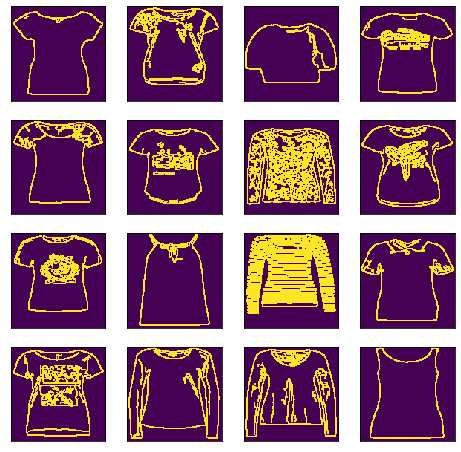

In [11]:
vis_batch(batch[0],16)

initialize network with normal
initialize network with normal
last_exp iter17110_lr0.0002
start_epoch 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


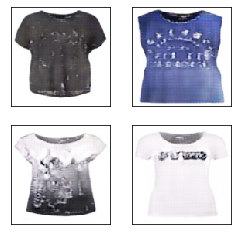

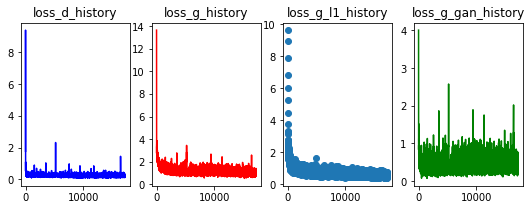

In [0]:
netG = define_G(input_nc, output_nc, ngf, 'batch', False, 'normal', 0.02, gpu_id=device)
netD = define_D(input_nc + output_nc, ndf, 'basic', gpu_id=device)

criterionGAN = GANLoss().to(device)
criterionL1 = nn.L1Loss().to(device)
criterionMSE = nn.MSELoss().to(device)

# setup optimizer
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
netG_scheduler = get_scheduler(optimizerG, opt)
netD_scheduler = get_scheduler(optimizerD, opt)

continue_training = True
N = len(training_data_loader)
exp_path = './models/'
if not os.path.isdir(exp_path):
    os.mkdir(exp_path)

if continue_training:
    last_exp = os.listdir(exp_path)[-1]
    print ("last_exp", last_exp)
    number = int(re.findall("iter\d+",last_exp)[0].replace('iter','')) 
    start_epoch = number // N 
    
    state_dict = torch.load(os.path.join(exp_path, last_exp))
    loss_d_history = state_dict['loss_d_history']
    loss_g_history = state_dict['loss_g_history']
    loss_g_l1_history  = state_dict['loss_g_l1_history']
    loss_g_gan_history  = state_dict['loss_g_gan_history']
    
    print ("start_epoch", start_epoch)
    
    netG.load_state_dict(state_dict['Generator'])
    optimizerG.load_state_dict(state_dict['OptGenerator'])
    netD.load_state_dict(state_dict['Discriminator'])
    optimizerD.load_state_dict(state_dict['OptDiscriminator'])
    
    for batch in training_data_loader:
        break
    fake = netG(batch[0].cuda())
    vis_batch(fake.detach(), 4)

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(9,3))

    axes[0].plot(loss_d_history, 'b')
    axes[0].set_title('loss_d_history')

    axes[1].plot(loss_g_history, 'r')
    axes[1].set_title('loss_g_history')
    
    axes[2].plot(loss_g_l1_history, 'o')
    axes[2].set_title('loss_g_l1_history')
    
    axes[3].plot(loss_g_gan_history, 'g')
    axes[3].set_title('loss_g_gan_history')
    
    plt.show()

else:
    start_epoch = 0
    loss_d_history = []
    loss_g_history = []
    loss_g_l1_history  = []
    loss_g_gan_history  = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

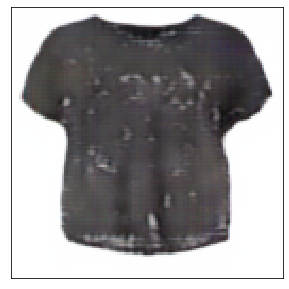

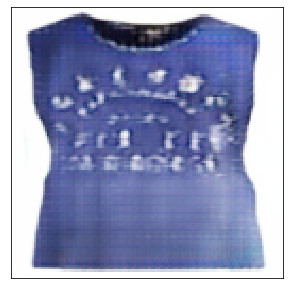

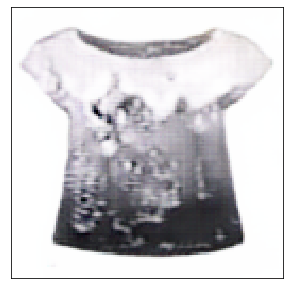

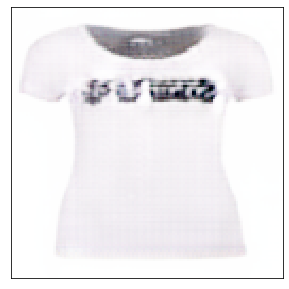

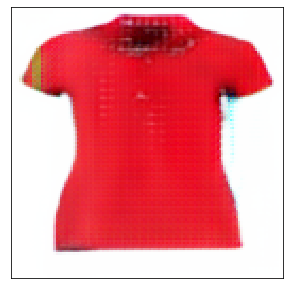

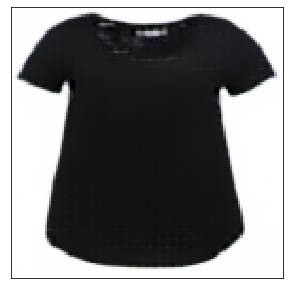

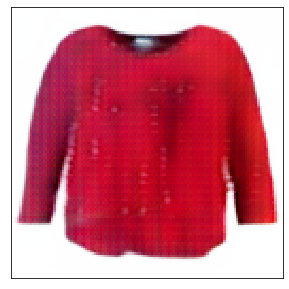

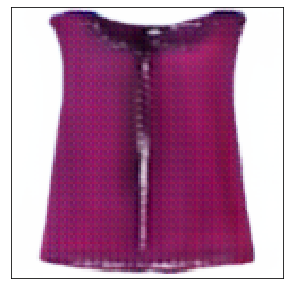

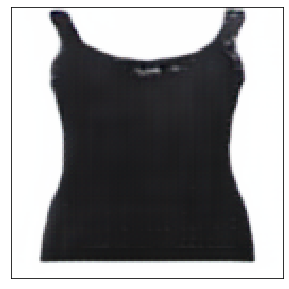

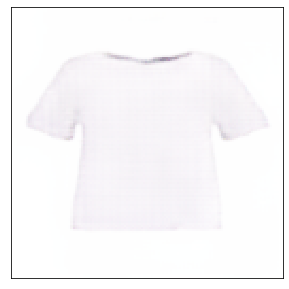

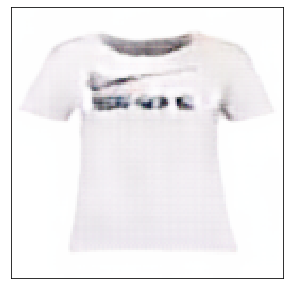

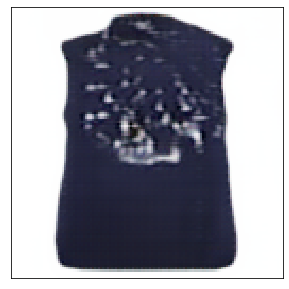

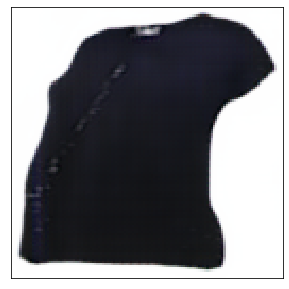

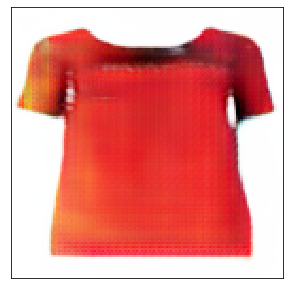

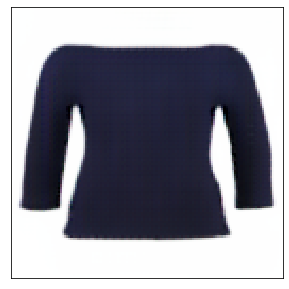

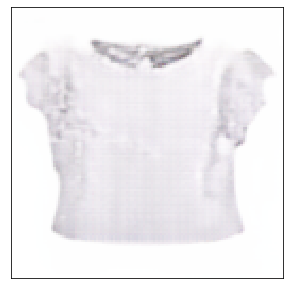

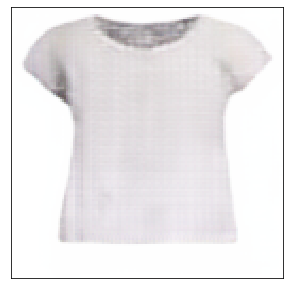

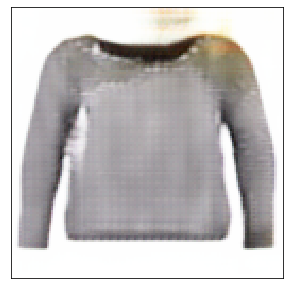

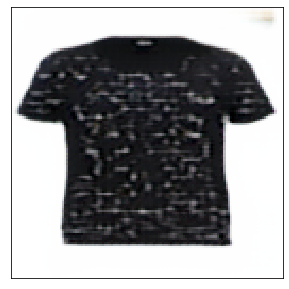

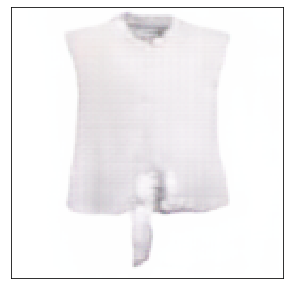

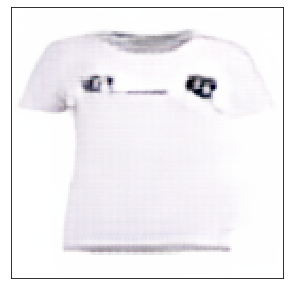

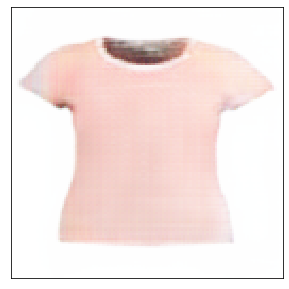

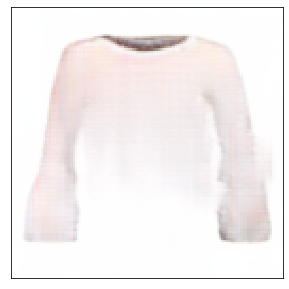

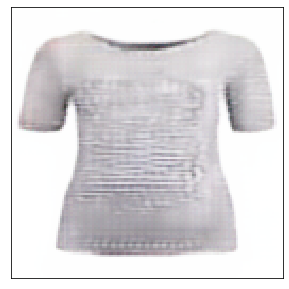

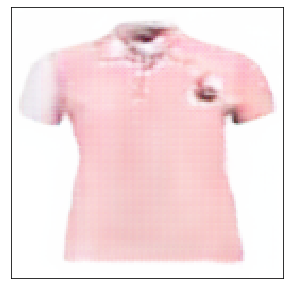

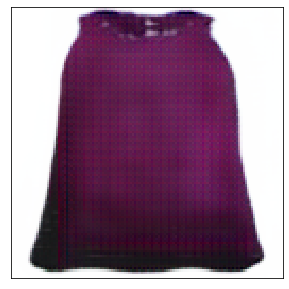

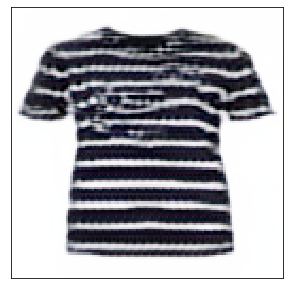

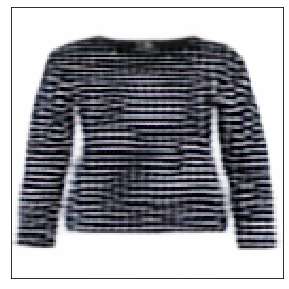

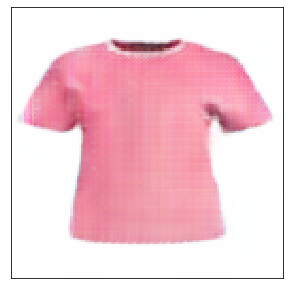

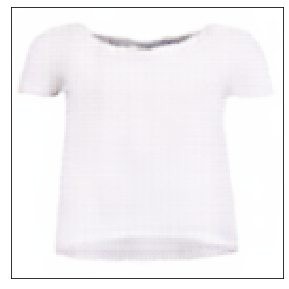

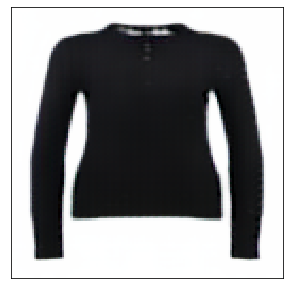

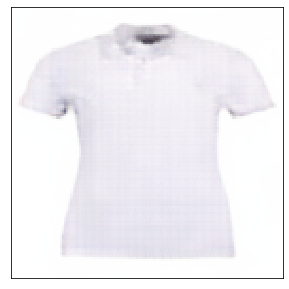

In [0]:
save_batch(fake)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


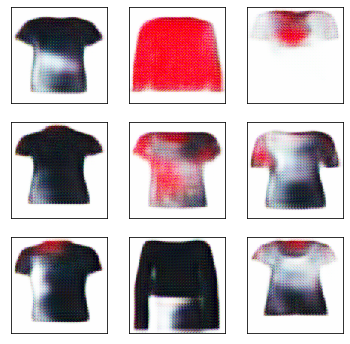

In [0]:
for epoch in range(start_epoch, niter + niter_decay + 1):
    # train
    for iteration, batch in enumerate(training_data_loader, 1):
        
        if batch is None:
            continue
        
        # forward
        real_a, real_b = batch[0].to(device), batch[1].to(device)
        fake_b = netG(real_a)

        ######################
        # (1) Update D network
        ######################
        print ('Update D network, epoch {0}, iter: {1}'.format(epoch, iteration))

        optimizerD.zero_grad()
        
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = netD.forward(fake_ab.detach())
        loss_d_fake = criterionGAN(pred_fake, False)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = netD.forward(real_ab)
        loss_d_real = criterionGAN(pred_real, True)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5
        loss_d.backward()
        loss_d_history.append(loss_d.item())
       
        optimizerD.step()

        ######################
        # (2) Update G network
        ######################
        print ('Update G network, epoch {0}, iter: {1}'.format(epoch, iteration))

        optimizerG.zero_grad()

        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = netD.forward(fake_ab)
        loss_g_gan = criterionGAN(pred_fake, True)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * lamb
        loss_g = loss_g_gan + loss_g_l1
        loss_g.backward()
        
        loss_g_history.append(loss_g.item())
        loss_g_l1_history.append(loss_g_l1.item())
        loss_g_gan_history.append(loss_g_gan.item())
        
        
        optimizerG.step()
    
        if iteration%VIS_FREQ==0:
                clear_output(wait=True)
                vis_batch(fake_b.detach(),9)
                fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12,3))

                axes[0].plot(loss_d_history, 'b')
                axes[0].set_title('loss_d_history')

                axes[1].plot(loss_g_history, 'r')
                axes[1].set_title('loss_g_history')

                axes[2].plot(loss_g_l1_history, 'o')
                axes[2].set_title('loss_g_l1_history')

                axes[3].plot(loss_g_gan_history, 'g')
                axes[3].set_title('loss_g_gan_history')
                
                plt.show()
                
        #checkpoint
        if iteration%SAVE_FREQ==0:
            save(exp_path, N*epoch + iteration,netD,netG,optimizerD,optimizerG,loss_d_history,loss_g_history,loss_g_l1_history,loss_g_gan_history)
    
    update_learning_rate(netG_scheduler, optimizerG)
    update_learning_rate(netD_scheduler, optimizerD)

        

    
